In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np

# Load training data
X_train = pd.read_csv("../data/train/X_train.csv")
y_train = pd.read_csv("../data/train/y_train.csv")

# Load test data
X_test = pd.read_csv("../data/test/X_test.csv")
y_test = pd.read_csv("../data/test/y_test.csv")

# If y_train/y_test is stored as a DataFrame, convert to Series
y_train = y_train.squeeze()  
y_test = y_test.squeeze()  

In [2]:
# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8852
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     45139
           1       0.61      0.03      0.06      5931

    accuracy                           0.89     51070
   macro avg       0.75      0.52      0.50     51070
weighted avg       0.85      0.89      0.84     51070



In [3]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check new class distribution
print("Class distribution after SMOTE:", Counter(y_train_smote))

# Initialize undersampler
undersampler = RandomUnderSampler(random_state=42)

# Apply undersampling
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

# Check new class distribution
print("Class distribution after undersampling:", Counter(y_train_under))

Class distribution after SMOTE: Counter({0: 180555, 1: 180555})
Class distribution after undersampling: Counter({0: 23722, 1: 23722})


In [4]:
# Train logistic regression model on undersampled data
model = LogisticRegression()
model.fit(X_train_under, y_train_under)

# Predictions
y_pred_under = model.predict(X_test)

# Evaluate model
accuracy_under = accuracy_score(y_test, y_pred_under)
print(f"Accuracy: {accuracy_under:.4f}")
print(classification_report(y_test, y_pred_under))

# Train logistic regression model on SMOTE data
model = LogisticRegression()
model.fit(X_train_smote, y_train_smote)

# Predictions
y_pred_smote = model.predict(X_test)

# Evaluate model
accuracy_smote = accuracy_score(y_test, y_pred_smote)
print(f"Accuracy: {accuracy_smote:.4f}")
print(classification_report(y_test, y_pred_smote))

# Train model with balanced class weights
clf = LogisticRegression(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

Accuracy: 0.6768
              precision    recall  f1-score   support

           0       0.94      0.67      0.79     45139
           1       0.22      0.70      0.33      5931

    accuracy                           0.68     51070
   macro avg       0.58      0.69      0.56     51070
weighted avg       0.86      0.68      0.73     51070

Accuracy: 0.6840
              precision    recall  f1-score   support

           0       0.94      0.68      0.79     45139
           1       0.22      0.69      0.34      5931

    accuracy                           0.68     51070
   macro avg       0.58      0.69      0.57     51070
weighted avg       0.86      0.68      0.74     51070

              precision    recall  f1-score   support

           0       0.94      0.67      0.79     45139
           1       0.22      0.70      0.33      5931

    accuracy                           0.68     51070
   macro avg       0.58      0.69      0.56     51070
weighted avg       0.86      0.68      0

In [6]:
# Define parameter grid for XGBoost
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [100, 200],
    'scale_pos_weight': [1, 5, 10]  # Adjust for class imbalance
}

# Initialize XGBoost classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Perform grid search
grid_search = GridSearchCV(xgb, param_grid, scoring='f1', cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Train the best model
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_xgb:.4f}")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\azizk\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:49:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 1}
Accuracy: 0.8849
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     45139
           1       0.53      0.09      0.15      5931

    accuracy                           0.88     51070
   macro avg       0.71      0.54      0.54     51070
weighted avg       0.85      0.88      0.85     51070



In [8]:
# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [1, 5],
    'min_samples_leaf': [2, 5],
    'class_weight': ['balanced']
}

# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42)

# Perform grid search
grid_search_rf = GridSearchCV(rf, param_grid_rf, scoring='f1', cv=5, verbose=2, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Get best model
best_rf = grid_search_rf.best_estimator_

# Evaluate
y_pred_rf = best_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\azizk\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\azizk\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\azizk\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "C:\Us

              precision    recall  f1-score   support

           0       0.94      0.74      0.83     45139
           1       0.24      0.63      0.35      5931

    accuracy                           0.73     51070
   macro avg       0.59      0.69      0.59     51070
weighted avg       0.86      0.73      0.77     51070



In [9]:
# Define parameter grid for LightGBM
param_grid_lgbm = {
    'num_leaves': [100],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [100, 200]
}

# Initialize LightGBM model
lgbm = lgb.LGBMClassifier(random_state=42)

# Perform grid search
grid_search_lgbm = GridSearchCV(lgbm, param_grid_lgbm, scoring='f1', cv=5, verbose=2, n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

# Get best model
best_lgbm = grid_search_lgbm.best_estimator_

# Evaluate
y_pred_lgbm = best_lgbm.predict(X_test)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
print(f"Accuracy: {accuracy_lgbm:.4f}")
print(classification_report(y_test, y_pred_lgbm))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Info] Number of positive: 23722, number of negative: 180555
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1327
[LightGBM] [Info] Number of data points in the train set: 204277, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116127 -> initscore=-2.029633
[LightGBM] [Info] Start training from score -2.029633
Accuracy: 0.8839
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     45139
           1       0.50      0.09      0.15      5931

    accuracy                           0.88     51070
   macro avg       0.70      0.54      0.54     51070
weighted avg       0.85      0.88      0.85     51070



C:\Users\azizk\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [10]:
# Stacking Classifier
final_model = StackingClassifier(
    estimators=[('xgb', best_xgb), ('rf', best_rf)],
    final_estimator=LogisticRegression()
)
final_model.fit(X_train, y_train)

# Evaluate
y_pred_final = final_model.predict(X_test)
accuracy_final = accuracy_score(y_test, y_pred_final)
print(f"Accuracy: {accuracy_final:.4f}")
print(classification_report(y_test, y_pred_final))

C:\Users\azizk\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:44:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\azizk\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:45:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\azizk\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:45:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Accuracy: 0.8858
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     45139
           1       0.59      0.06      0.10      5931

    accuracy                           0.89     51070
   macro avg       0.74      0.53      0.52     51070
weighted avg       0.85      0.89      0.84     51070



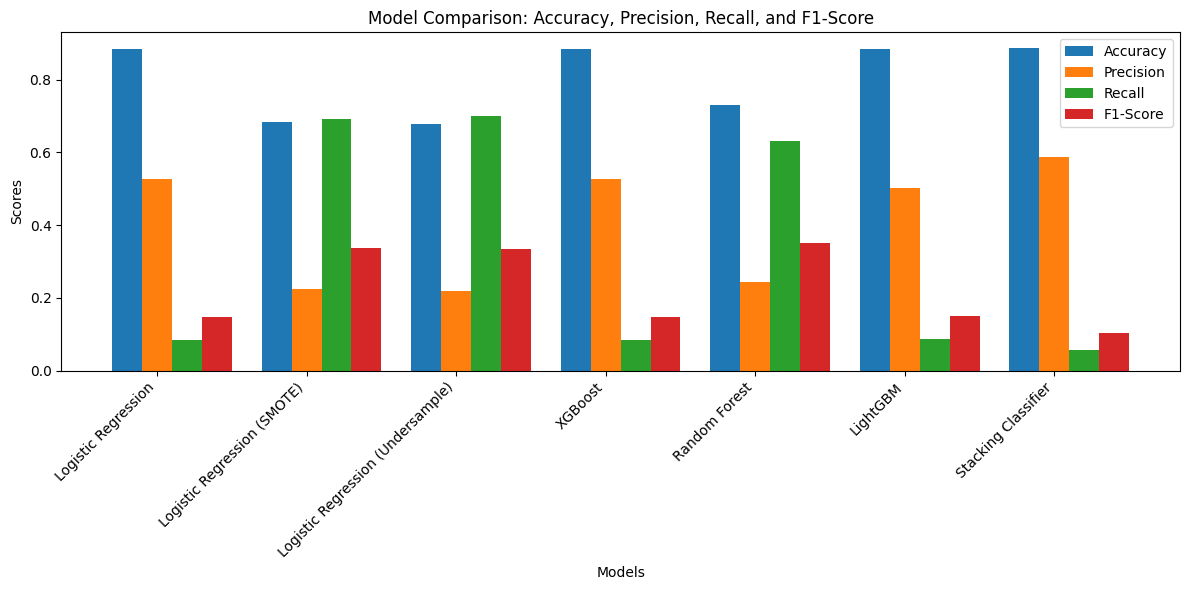

In [11]:
# Collect metrics for comparison
models = ['Logistic Regression', 'Logistic Regression (SMOTE)', 'Logistic Regression (Undersample)', 
          'XGBoost', 'Random Forest', 'LightGBM', 'Stacking Classifier']
accuracies = [accuracy, accuracy_smote, accuracy_under, accuracy_xgb, 
              accuracy_score(y_test, y_pred_rf), accuracy_lgbm, accuracy_final]
precisions = [precision_score(y_test, y_pred), precision_score(y_test, y_pred_smote), 
              precision_score(y_test, y_pred_under), precision_score(y_test, y_pred), 
              precision_score(y_test, y_pred_rf), precision_score(y_test, y_pred_lgbm), 
              precision_score(y_test, y_pred_final)]
recalls = [recall_score(y_test, y_pred), recall_score(y_test, y_pred_smote), 
           recall_score(y_test, y_pred_under), recall_score(y_test, y_pred), 
           recall_score(y_test, y_pred_rf), recall_score(y_test, y_pred_lgbm), 
           recall_score(y_test, y_pred_final)]
f1_scores = [f1_score(y_test, y_pred), f1_score(y_test, y_pred_smote), 
             f1_score(y_test, y_pred_under), f1_score(y_test, y_pred), 
             f1_score(y_test, y_pred_rf), f1_score(y_test, y_pred_lgbm), 
             f1_score(y_test, y_pred_final)]

# Plot comparison graph
x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, accuracies, width, label='Accuracy')
rects2 = ax.bar(x, precisions, width, label='Precision')
rects3 = ax.bar(x + width, recalls, width, label='Recall')
rects4 = ax.bar(x + 2 * width, f1_scores, width, label='F1-Score')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Model Comparison: Accuracy, Precision, Recall, and F1-Score')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()

fig.tight_layout()
plt.show()